In [1]:
from openmm.app import *
from openmm import *
from openmm import unit as u
import sys
import mdtraj as md
import numpy as np
from tqdm import tqdm

In [2]:
# Nombre del archivo PDB del péptido
pdb_filename = "pdbs/V5.pdb"

In [3]:
# Cargar la estructura del péptido desde el archivo PDB
pdb = PDBFile(pdb_filename)

In [4]:
# Definir la fuerza de campo (AMBER ff14SB es común para péptidos)
forcefield = ForceField("amber14-all.xml", "amber14/tip3p.xml")

In [5]:
# Crear el sistema en vacío (sin agua ni iones)
system = forcefield.createSystem(
    pdb.topology,
    nonbondedMethod=NoCutoff,  # Sin tratamiento de fronteras periódicas
    constraints=HBonds         # Restringe enlaces de hidrógeno para un paso de integración más largo
)

In [6]:
# Configurar el integrador (Langevin dynamics)
temperature = 300 * u.kelvin
friction = 1 / u.picosecond
timestep = 2 * u.femtoseconds
integrator = LangevinIntegrator(temperature, friction, timestep)

In [7]:
# Crear una plataforma para ejecutar la simulación (e.g., CUDA si tienes GPU)
platform = Platform.getPlatformByName("CUDA")  # Usa "CPU" si no tienes GPU

In [8]:
# Configurar la simulación
simulation = Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

In [9]:
state = simulation.context.getState(getEnergy=True)
energy = state.getPotentialEnergy()

In [10]:
print('Energy before minimization:', energy)

Energy before minimization: 50835052.372887135 kJ/mol


In [11]:
# Minimización de energía
print("Minimizando energía...")
simulation.minimizeEnergy()

Minimizando energía...


In [12]:
state = simulation.context.getState(getEnergy=True)
energy = state.getPotentialEnergy()
print('Energy after minimization:', energy)

Energy after minimization: 141.4972814321518 kJ/mol


In [13]:
md_topology = md.Topology.from_openmm(simulation.topology)

In [14]:
steps_segment = 1000
n_segments = 5000

In [15]:
def es_el_mismo(angs1, angs2):
    if np.max(np.abs(angs1-angs2))<0.1:
        return True
    else:
        return False

In [16]:
traj_inh_db = []
unique_db = []

In [17]:
for ii in tqdm(range(n_segments)):
    simulation.step(steps_segment)
    state = simulation.context.getState(getEnergy=True)
    energy = state.getPotentialEnergy()
    simulation.minimizeEnergy()
    min_state = simulation.context.getState(getEnergy=True, getPositions=True)
    min_energy = min_state.getPotentialEnergy()
    min_positions = min_state.getPositions(asNumpy=True)
    traj = md.Trajectory(min_positions / u.nanometer, md_topology)
    phis = md.compute_phi(traj)[1]
    psis = md.compute_psi(traj)[1]
    dihed_angs=np.concatenate((phis[0],psis[0]))
    visitado = False
    for unique_index in range(len(unique_db)):
        aux = es_el_mismo(dihed_angs, unique_db[unique_index])
        if aux == True:
            visitado = True
            traj_inh_db.append(unique_index)
            break
    if visitado == False:
        traj_inh_db.append(len(unique_db))
        unique_db.append(dihed_angs)
    #print(ii, energy, min_energy, phis, psis)
    #print(dihed_angs)

100%|██████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:52<00:00, 21.50it/s]


In [18]:
pesos_transiciones={}
pesos_nodos={}

In [19]:
for ii in range(len(traj_inh_db)-1):
    nodo_1 = traj_inh_db[ii]
    nodo_2 = traj_inh_db[ii+1]
    if (nodo_1, nodo_2) in pesos_transiciones:
        pesos_transiciones[nodo_1, nodo_2]+=1
    else:
        pesos_transiciones[nodo_1, nodo_2]=1
    if nodo_1 in pesos_nodos:
        pesos_nodos[nodo_1]+=1
    else:
        pesos_nodos[nodo_1]=1

In [20]:
#pesos_nodos

In [21]:
#unique_db[33]

In [22]:
#pesos_transiciones

In [23]:
import networkx as nx

In [24]:
# Crear el grafo (puedes usar nx.Graph para un grafo no dirigido)
G = nx.DiGraph()  # Para un grafo dirigido

In [25]:
# Agregar las aristas desde el diccionario
for nodes, peso in pesos_transiciones.items():
    G.add_edge(nodes[0], nodes[1])

In [26]:
import matplotlib.pyplot as plt

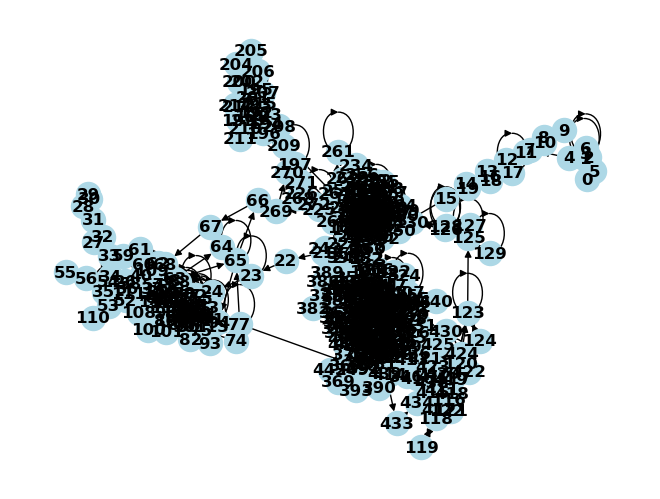

In [27]:
nx.draw(G, with_labels=True, node_color="lightblue", font_weight="bold")
plt.show()